### Imports

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# LemmaTokenizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
#--------
# main ones to focus on for this sprint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Covered in sprint 3
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Covered in sprint 4
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Neural Network!!
from sklearn.neural_network import MLPClassifier

### Import and Prep data

In [62]:
mbti = pd.read_csv('data/train.csv')
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [63]:
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'posts'])

In [64]:
all_mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


Split MBTI type into individual features for Binary Classification

In [65]:
def split_type(row):
    ''' 
       Split MBTI type into individual features for Binary Classification
       eg ENFP = [0 1 0 0]
    '''
    t = row['type']
    I,N,T,J = 0,0,0,0
    
    I = 1 if t[0] =='I' else 0
    
    N = 1 if t[1] == 'N' else 0
    
    T = 1 if t[2] == 'T' else 0
    
    J = 1 if t[3] == 'J' else 0
    
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [66]:
all_mbti = all_mbti.join(all_mbti.apply(lambda row: split_type(row), axis=1))
all_mbti.head(5)

,type,posts,IE,JP,NS,TF
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,1,1,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,1,1,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,1,1,1,0
3,INFJ,What has been the most life-changing experienc...,1,1,1,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,1,1,1,0


In [67]:
# rearrange columns
all_mbti = all_mbti[['type', 'IE', 'NS', 'TF', 'JP', 'posts']]
all_mbti.head(5)

,type,IE,NS,TF,JP,posts
0,INFJ,1,1,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,1,1,0,1,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,1,1,0,1,enfp and intj moments https://www.youtube.com...
3,INFJ,1,1,0,1,What has been the most life-changing experienc...
4,INFJ,1,1,0,1,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


Note: create_function to run here 1st

---
### Clean the text

creating the LemmaTokenizer removes the default tokenizer, therefore cleaning of the data has to be done manually

In [68]:
all_mbti['posts'].head(10)

0          'http://www.youtube.com/watch?v=qsXHcwe3krw
1    http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2    enfp and intj moments  https://www.youtube.com...
3    What has been the most life-changing experienc...
4    http://www.youtube.com/watch?v=vXZeYwwRDw8   h...
5                 May the PerC Experience immerse you.
6    The last thing my INFJ friend posted on his fa...
7    Hello ENFJ7. Sorry to hear of your distress. I...
8    84389  84390  http://wallpaperpassion.com/uplo...
9                                   Welcome and stuff.
Name: posts, dtype: object

In [69]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['posts'] = all_mbti['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

all_mbti['posts'] = all_mbti['posts'].str.replace('\d+', '') # remove digits

all_mbti['posts'] = all_mbti['posts'].str.replace(r'(\b\w{1,2}\b)', '') # remove words less than 3 letters

all_mbti['posts'] = all_mbti['posts'].str.replace('[^\w\s]', '') # remove punctuation 

all_mbti['posts'].head(10)

0                                               urlweb
1                                               urlweb
2    enfp and intj moments  urlweb  sportscenter no...
3    What has been the most lifechanging experience...
4             urlweb   urlweb   repeat for most  today
5                  May the PerC Experience immerse you
6    The last thing  INFJ friend posted  his facebo...
7    Hello ENFJ Sorry  hear  your distress  only na...
8                                      urlweb  urlweb 
9                                    Welcome and stuff
Name: posts, dtype: object

---
### Custom builds

build my own tokenizer that lemmatizes as well

In [70]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode', # works 
                                stop_words = 'english', # works
                                lowercase = True, # works
                                max_df = 0.5, # works
                                min_df = 10) # works

bespoke stopwords list

In [25]:
# my_stopwords1

# my_stopwords1

### Train, test split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(all_mbti['posts'], all_mbti['IE'], test_size=0.3, 
                                                    random_state=42)

### Building Pipelines

##### baseline

In [77]:
baseline = Pipeline([('cnt_vec', CountVectorizer(stop_words='english')),
                     ('bayes', MultinomialNB())
                    ])

baseline_lem = Pipeline([('lem_vec', CountVectorizer(tokenizer=LemmaTokenizer(),stop_words='english')),
                          ('bayes', MultinomialNB())
                        ])

baseline_tfidf = Pipeline([('lem_vec', TfidfVectorizer(stop_words='english')),
                           ('bayes', MultinomialNB())
                         ])

baseline_tfidf_lem = Pipeline([('count_vec', TfidfVectorizer( binary=True, min_df=3, ngram_range=(1,2), stop_words='english')),
                               ('bayes', MultinomialNB(alpha=0.1))
                              ])

forest_pipe = Pipeline([('count_vec', TfidfVectorizer( binary=True, min_df=3, ngram_range=(1,2), stop_words='english')),
                        ('forest', RandomForestClassifier(n_estimators=10, random_state=2, class_weight="balanced", criterion='gini'))
                       ])

forest_pipe_lem = Pipeline([('count_vec', TfidfVectorizer(tokenizer=LemmaTokenizer(), binary=True, min_df=3, ngram_range=(1,2), stop_words='english')),
                        ('forest', RandomForestClassifier(n_estimators=10, random_state=2, class_weight="balanced", criterion='gini'))
                       ])

logreg = Pipeline([('count_vec', TfidfVectorizer(tokenizer=LemmaTokenizer(), binary=True, min_df=3, ngram_range=(1,2), stop_words='english')),
                        ('logreg', LogisticRegression(C=1., random_state=2, penalty='l1', class_weight="balanced"))
                       ])

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gradboost = Pipeline([('count_vec', TfidfVectorizer( binary=True, min_df=3, ngram_range=(1,2), stop_words='english')),
                        ('gradboost', GradientBoostingClassifier(n_estimators=20, random_state=2, loss='exponential'))
                       ])

### Assessing Baselines

In [31]:
pipelines = [baseline,baseline_lem, baseline_tfidf, baseline_tfidf_lem]
names_of_pipes = ['baseline', 'baseline_lem', 'baseline_tfidf', 'baseline_tfidf_lem']

In [32]:
pipelines = [forest_pipe_lem, forest_pipe, baseline_tfidf_lem]
names_of_pipes = ['forest_pipe_lem', 'forest_pipe', 'baseline_tfidf_lem']

In [74]:
pipelines =[logreg]
names_of_pipes = ['logreg']

Loop through the Pipelines:

In [78]:
results = []
models = {}
confusion = {}
class_report = {}

for name, pipe in zip(names_of_pipes, pipelines):
    print(f'For model {name}:')
    
    # time model training
    #start = timeit.default_timer()
    %time  pipe.fit(X_train, y_train)
    #stop = timeit.default_timer()
    #print('The model took {:.3f} seconds to train'.format(stop - start)) 
    #print('The model took {:.3f} seconds to train'.format(run_time)) 
    
    print ('... predicting')
    y_pred = pipe.predict(X_train)   
    y_pred_test = pipe.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)
    # score train vs test
    print("\nAccuracy on training set: {:.3f}".format(pipe.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(pipe.score(X_test, y_test)))
    
    # save the results to dictionaries
    models[name] = name    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test])
    
    # Assessment
    #y_pred = pipe.predict(X_test)
    #print('\nConfusion Matrix:')
    #print(confusion_matrix(y_pred, y_test))
    #print('\nClassification Report:')
    #print(classification_report(y_pred, y_test))
    
    print('----------------------------------------------------------------\n')
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test'])
results.set_index('Classifier', inplace= True)

For model logreg:
CPU times: user 1min 24s, sys: 1.09 s, total: 1min 25s
Wall time: 1min 27s
... predicting
... scoring

Accuracy on training set: 0.778
Accuracy on test set: 0.769
----------------------------------------------------------------



AssertionError: 7 columns passed, passed data had 6 columns

In [79]:
results

[['logreg',
  0.77777176046898899,
  0.78018014685482828,
  0.99001349527665317,
  0.87266031890519213,
  0.86699388136752342]]

In [50]:
confusion['logreg']

array([[   292,  50861],
       [   147, 170283]])

---

In [88]:
from sklearn.model_selection import GridSearchCV


In [89]:
params = {'logreg__C':[10,1,0.1,0.001]}

In [91]:
log_grid = GridSearchCV(logreg,params,scoring='f1')

In [92]:
log_grid.fit(X_train, y_train)

/Users/wahe3bru/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wahe3bru/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wahe3bru/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vec', TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...nalty='l1', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': [10, 1, 0.1, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [93]:
log_grid.best_params_

{'logreg__C': 0.1}

In [94]:
log_grid.grid_scores_

/Users/wahe3bru/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.75566, std: 0.00197, params: {'logreg__C': 10},
 mean: 0.73618, std: 0.00136, params: {'logreg__C': 1},
 mean: 0.79470, std: 0.00346, params: {'logreg__C': 0.1},
 mean: 0.00000, std: 0.00000, params: {'logreg__C': 0.001}]

---

In [25]:
results

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
baseline,0.809187,0.812716,0.977076,0.887349,0.860728,"Pipeline(memory=None,\n steps=[('cnt_vec',..."
baseline_lem,0.807210,0.811203,0.976647,0.886270,0.861238,"Pipeline(memory=None,\n steps=[('lem_vec',..."
baseline_tfidf,0.776039,0.774852,0.999137,0.872816,0.867733,"Pipeline(memory=None,\n steps=[('lem_vec',..."
baseline_tfidf_lem,0.775867,0.774740,0.999085,0.872726,0.867768,"Pipeline(memory=None,\n steps=[('lem_vec',..."


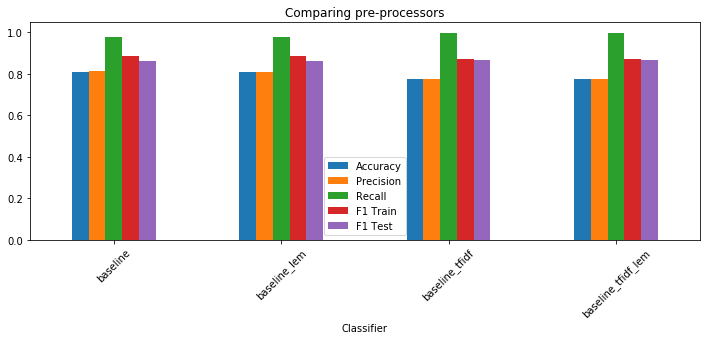

In [26]:
results[['Accuracy','Precision','Recall','F1 Train','F1 Test']].plot.bar(figsize=(12,4), title="Comparing pre-processors", rot=45)
plt.show()

baseline perform better than the rest except in 'F1 test'.

i will be comparing the models using the train data after CountVectorizer(default values) has transformed the text

In [112]:
all_mbti.head()

,type,IE,NS,TF,JP,post
0,INFJ,1,1,0,1,urlweb
1,INFJ,1,1,0,1,urlweb
2,INFJ,1,1,0,1,enfp and intj moments urlweb sportscenter no...
3,INFJ,1,1,0,1,What has been the most lifechanging experience...
4,INFJ,1,1,0,1,urlweb urlweb repeat for most today


In [122]:
vect = CountVectorizer()
X = vect.fit_transform(all_mbti['post'])

In [123]:
y = all_mbti['IE']

In [124]:
n = 3000
X_train, X_test, y_train, y_test = train_test_split(X[:n].toarray(), y[:n])

In [125]:
names = ['Logistic Regression', 
         'Nearest Neighbors', 
         'Linear SVM', 
         'RBF SVM', 
         'Naive Bayes', 
         'LDA', 
         "QDA",          
         "Decision Tree", "Random Forest",  "AdaBoost", 
         "Neural Net"]

In [126]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),    
    GaussianNB(),    
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),    
    
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier(),
    
    MLPClassifier(alpha=1)    
]

In [134]:
results = []
models = {}
confusion = {}
class_report = {}

In [137]:
name       = 'forest'
classifiers = RandomForestClassifier(n_estimators=50, random_state=2, class_weight="balanced", criterion='gini')


In [138]:
print ('Fitting {:s} model...'.format(name))
run_time = %timeit -q -o clf.fit(X_train, y_train)
print(f'time taken to train: {run_time}')
print ('... predicting')
y_pred = clf.predict(X_train)   
y_pred_test = clf.predict(X_test)
    
print ('... scoring')
accuracy  = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall    = metrics.recall_score(y_test, y_pred_test)
    
f1        = metrics.f1_score(y_train, y_pred)    
f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
# save the results to dictionaries
models[name] = classifiers    
confusion[name] = metrics.confusion_matrix(y_train, y_pred)
class_report[name] = metrics.classification_report(y_train, y_pred)
print('Done')
    
results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

Fitting forest model...


/Users/wahe3bru/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


time taken to train: 2min 58s ± 4.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
... predicting
... scoring
Done


In [139]:
    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

In [140]:
results

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
forest,0.593333,0.824153,0.636661,0.995683,0.718375,172.430165


In [ ]:
# Logistic Regression	0.593333	0.824153	0.636661	0.995683	0.718375	152.430359

In [ ]:
params = {'C'}

In [ ]:
log_grid = GridSearchCV(legreg, params, scoring='f1')